# <b> <font color='#A20025'> 📚 Chapter 1: The Drug Discovery Process

*This notebook contains the code examples in chapter 1. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH01_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- What is drug discovery and how it relates to drug development
- What does it mean to discover a drug
- How machine learning and deep learning aid in drug discovery
- A foundation of drug discovery and machine learning terminology
- Publicly accessible chemical data repositories to consider for your own projects


## <b> <font color='#A20025'> ⚙️ Environment Setup 

**❗️LOCAL ENVIRONMENT:** If you are running the Python notebook locally on your computer, then we recommend following the README setup instructions on how to use conda (or a similar package) to set up an environment using the file `ml4dd2025.yml`

**❗️COLAB ENVIRONMENT:** If you are running the code via an instance on Google Colab, you can download the necessary files and create the environment by running the following cells marked as **Colab users only**.

In [ ]:
# Colab users only
import os
CHAPTER = "ch01"
os.makedirs(f"artifacts/{CHAPTER}", exist_ok=True)
os.makedirs(f"data/{CHAPTER}", exist_ok=True)
os.makedirs(f"figures/{CHAPTER}", exist_ok=True)
!wget --recursive "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/data/ch01/fda_approved_drugs" -O "data/ch01/fda_approved_drugs"
!wet "https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/ml4dd2025.yml" "env.yml"

In [ ]:
# Colab users only
!pip install -q condacolab
import condacolab
condacolab.install() #  The kernel will restart after this cell has run, which is normal.

In [ ]:
# Colab users only
# Verify condalab installation
import condacolab
condacolab.check()

In [ ]:
# Colab users only
# We can only use the base environment in `condacolab`, so we will update it with the `env.yml` file we downloaded earlier.
!mamba env update -n base -f env.yml

### <b> <font color='#A20025'> Import Packages 

Now let's import all the packages we'll need for this chapter.

In [6]:
# Core data science packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chemical informatics packages
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    Descriptors,
    Draw, 
    PandasTools,
)

# Machine learning packages
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Define any constants
CHAPTER = "ch01"

# Set random seed for reproducibility
np.random.seed(41)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette(sns.color_palette('PuBu'))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16

setup_visualization_style()
%matplotlib inline

In [9]:
# RDKit drawing setup
def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15
    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

## **<font color='#A20025'>1️⃣ Deep Learning's Value Proposition</font>**

*Companion code does not accompany this section of the book.*

## **<font color='#A20025'>2️⃣ What is Machine Learning? What is a Molecule?</font>**

This section demonstrates how we can represent molecules computationally and apply machine learning techniques to them. We'll explore:
 
1. How to use RDKit to handle molecular structures
2. How to visualize molecules
3. How to apply basic ML techniques to chemical data

### <b> <font color='#A20025'> An Example Application with USAN Stems & RDKit

#### <b> <font color='#A20025'> RDKit: Open-Source Cheminformatics Software

[RDKit](https://www.rdkit.org/) is an open-source cheminformatics toolkit that allows us to:
- Read and write various chemical file formats
- Generate 2D and 3D representations of molecules
- Calculate molecular descriptors and fingerprints
- Perform substructure searching and other operations
 
Let's start with a simple example using the caffeine molecule:

In [10]:
def create_molecule_from_smiles(smiles):
    """
    Convert a SMILES string to an RDKit molecule object.
    
    Parameters:
    -----------
    smiles : str
        SMILES representation of a molecule
        
    Returns:
    --------
    rdkit.Chem.rdchem.Mol
        RDKit molecule object, or None if parsing fails
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Warning: Could not parse SMILES string: {smiles}")
    return mol

def display_molecule_properties(mol):
    """
    Display basic properties of an RDKit molecule object.
    
    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object
    """
    if mol is None:
        print("No valid molecule to display")
        return
    
    print(f"Chemical Formula: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")
    print(f"Number of atoms: {mol.GetNumAtoms()}")
    print(f"Number of bonds: {mol.GetNumBonds()}")
    print(f"Number of rings: {Chem.rdMolDescriptors.CalcNumRings(mol)}")
    
    # Calculate basic molecular properties
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    
    print(f"Molecular Weight: {mw:.2f}")
    print(f"LogP: {logp:.2f}")
    print(f"Topological Polar Surface Area: {tpsa:.2f}")

Let's examine caffeine as our first example molecule.

Chemical Formula: C8H10N4O2
Number of atoms: 14
Number of bonds: 15
Number of rings: 2
Molecular Weight: 194.19
LogP: -1.03
Topological Polar Surface Area: 61.82


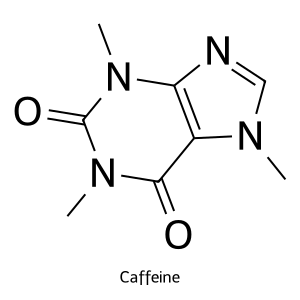

In [13]:
# SMILES representation of caffeine
caffeine_smiles = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"

# Create an RDKit molecule object from the SMILES string
caffeine_mol = create_molecule_from_smiles(caffeine_smiles)

# Display properties of the caffeine molecule
display_molecule_properties(caffeine_mol)

# Visualize the molecule
caffeine_img = Draw.MolsToGridImage(
    mols=[caffeine_mol], 
    molsPerRow=1, 
    subImgSize=(300, 300),
    legends=["Caffeine"],
    useSVG=True, 
    drawOptions=rdkit_drawing_options
)
caffeine_img

In [16]:
# Save the image for use outside of the notebook
def save_molecule_image(img, filename):
    """
    Save a molecule image to a file.
    
    Parameters:
    -----------
    img : rdkit.Chem.Draw._MolsToGridImage
        Image object from RDKit
    filename : str
        Path to save the image
    """
    with open(filename, "w") as f:
        f.write(img.data)
    print(f"Image saved to {filename}")

save_molecule_image(caffeine_img, f"figures/{CHAPTER}/caffeine.svg")

Image saved to figures/ch01/caffeine.svg


### <b> <font color='#A20025'> Example Applications with USAN Stems

United States Adopted Names (USAN) stems are name segments that provide information about a drug's chemical structure or pharmacological action. For example:
 
- **-caine**: Local anesthetics
- **-cillin**: Penicillin antibiotics
- **-olol**: Beta-blockers
 
Let's explore FDA-approved drugs based on their USAN stems to understand structural patterns in drug classes.

In [25]:
def load_usan_stem_data(stems, data_path=f"data/{CHAPTER}/fda_approved_drugs"):
    """
    Load and combine data for multiple USAN stems.
    
    Parameters:
    -----------
    stems : list
        List of USAN stem strings to load
    data_path : str
        Base path to data files
        
    Returns:
    --------
    pandas.DataFrame
        Combined dataframe with all stem data
    """
    import os
    os.makedirs(data_path, exist_ok=True)

    dfs = []
    for stem in stems:
        try:
            df = pd.read_csv(
                f'{data_path}/{stem}.csv',
                sep=';',
                usecols=['Name', 'Smiles', '#RO5 Violations (Lipinski)'],
            )
            df['USAN Stem'] = stem
            dfs.append(df)
            print(f"✓ Loaded data for {stem}")
        except Exception as e:
            print(f"✗ Failed to load data for {stem}: {str(e)}")
    
    if not dfs:
        raise ValueError("No data was loaded. Check the file paths and formats.")
        
    return pd.concat(dfs)

# Define USAN stems we'll explore
usan_stems = [
    '-caine', '-cillin', '-conazole', '-olol', 
    '-oxacin', '-pine', 'sulfa-', '-terol', 
    '-tinib', '-vir'
]

In [26]:
# Load data for all stems
try:
    fda_approved_df = load_usan_stem_data(usan_stems)
    print(f"\nLoaded data for {len(fda_approved_df)} drugs across {len(usan_stems)} USAN stems")
    
    # Display a summary of drugs per stem
    stem_counts = fda_approved_df.groupby('USAN Stem').size().sort_values(ascending=False)
    print("\nNumber of drugs per USAN stem:")
    print(stem_counts)
    
    # Save the combined data
    fda_approved_df.to_csv(f'data/{CHAPTER}/fda_approved_drugs/fda_approved_drugs.csv', sep=',', index=False)
    print("\nSaved combined data")
except Exception as e:
    print(f"Error loading data: {str(e)}")

✓ Loaded data for -caine
✓ Loaded data for -cillin
✓ Loaded data for -conazole
✓ Loaded data for -olol
✓ Loaded data for -oxacin
✓ Loaded data for -pine
✓ Loaded data for sulfa-
✓ Loaded data for -terol
✓ Loaded data for -tinib
✓ Loaded data for -vir

Loaded data for 343 drugs across 10 USAN stems

Number of drugs per USAN stem:
USAN Stem
-tinib       60
-cillin      46
-vir         40
-olol        37
-caine       33
-oxacin      29
-terol       29
-conazole    24
sulfa-       23
-pine        22
dtype: int64

Saved combined data


Now let's add RDKit molecule objects and molecular fingerprints to our dataframe, which will allow us to:
1. Visualize the molecules
2. Calculate molecular descriptors
3. Perform chemical similarity comparisons

In [27]:
def add_molecular_data(df, smiles_col='Smiles'):
    """
    Add RDKit molecule objects and fingerprints to a dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing SMILES strings
    smiles_col : str
        Column name containing SMILES strings
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe with added molecular information
    """
    # Add molecule objects
    print("Adding RDKit molecule objects...")
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol=smiles_col, molCol='ROMol')
    
    # Remove records with invalid molecules
    valid_mol_count = df['ROMol'].notnull().sum()
    invalid_mol_count = df['ROMol'].isnull().sum()
    print(f"Valid molecules: {valid_mol_count}")
    print(f"Invalid molecules: {invalid_mol_count}")
    
    if invalid_mol_count > 0:
        df = df[~df['ROMol'].isnull()]
        print(f"Removed {invalid_mol_count} records with invalid molecules")
    
    # Add fingerprints (Morgan/ECFP6)
    print("Generating molecular fingerprints (this may take a moment)...")
    df['ECFP6'] = df['ROMol'].apply(
        lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=3, nBits=1024)
    )
    print("Fingerprint generation complete")
    
    return df

# Add molecular data to our dataframe
fda_approved_df = add_molecular_data(fda_approved_df)

Adding RDKit molecule objects...
Valid molecules: 343
Invalid molecules: 0
Generating molecular fingerprints (this may take a moment)...
Fingerprint generation complete


In [30]:
def visualize_usan_stem_examples(df, stems, mol_col='ROMol', legend_col='USAN Stem'):
    """
    Create a grid visualization of example molecules for each USAN stem.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing molecules and stem information
    stems : list
        List of USAN stems to include
    mol_col : str
        Column name containing RDKit molecule objects
    legend_col : str
        Column name containing text for image legends
        
    Returns:
    --------
    rdkit.Chem.Draw._MolsToGridImage
        Grid image of molecules
    """
    sample_drugs = pd.concat(
        [df[df[legend_col] == stem].head(1) for stem in stems]
    )
    
    # Calculate grid dimensions
    n_molecules = len(sample_drugs)
    n_cols = min(4, n_molecules)  # Maximum 4 columns
    
    img = PandasTools.FrameToGridImage(
        sample_drugs, 
        legendsCol=legend_col, 
        molsPerRow=n_cols, 
        subImgSize=(250, 250),
        useSVG=True, 
        drawOptions=rdkit_drawing_options
    )
    
    return img, sample_drugs

# Create and display the visualization
usan_example_img, sample_drugs = visualize_usan_stem_examples(
    fda_approved_df, usan_stems
)

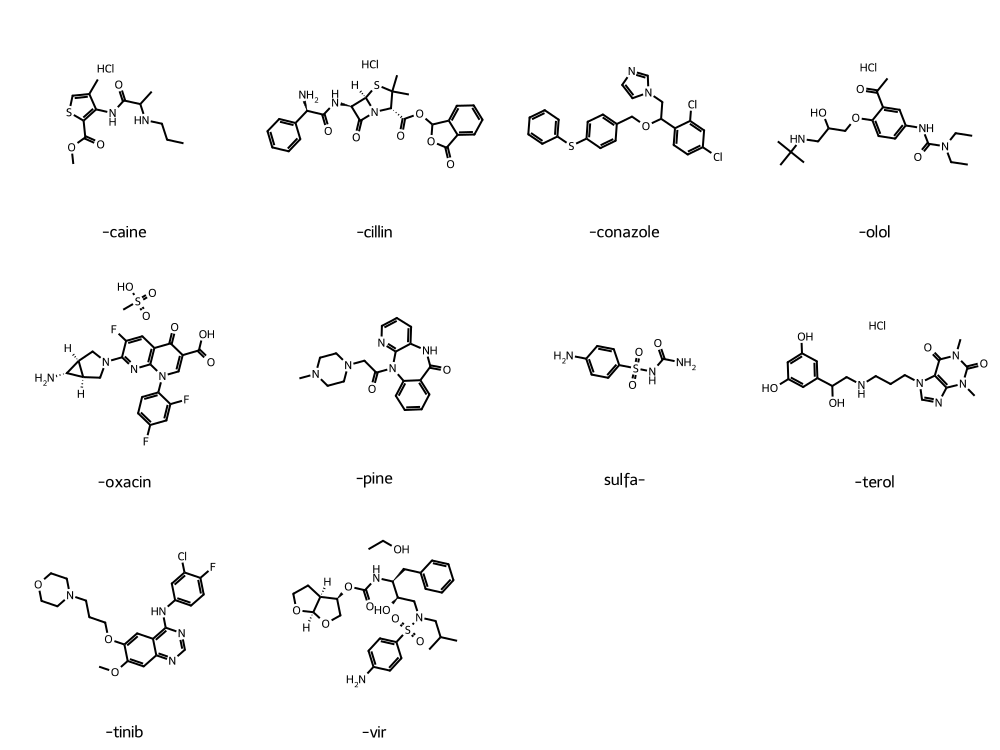

In [31]:
# Display the image
usan_example_img

In [32]:
# Save the image
save_molecule_image(usan_example_img, f"figures/{CHAPTER}/sampled_drugs.svg")

Image saved to figures/ch01/sampled_drugs.svg


#### <b> <font color='#A20025'> Unsupervised Learning Example: PCA

Now we'll use Principal Component Analysis (PCA) to reduce the dimensionality of our molecular fingerprints. This allows us to:
 
1. Visualize the chemical space of FDA-approved drugs
2. Identify patterns and clusters of similar drugs
3. Understand the distribution of different drug classes
 
PCA works by finding the directions (principal components) of maximum variance in the data.

In [33]:
def perform_pca_analysis(df, fingerprint_col='ECFP6', n_components=4):
    """
    Perform PCA on molecular fingerprints and add principal components to dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing molecular fingerprints
    fingerprint_col : str
        Column name containing fingerprints
    n_components : int
        Number of principal components to compute
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe with added principal components
    sklearn.decomposition.PCA
        Fitted PCA model
    """
    print(f"Performing PCA with {n_components} components...")
    
    # Extract fingerprints as a numpy array
    X = np.array([x for x in df[fingerprint_col]])
    
    # Initialize and fit PCA model
    pca = PCA(n_components=n_components, random_state=42)
    pca_result = pca.fit_transform(X)
    
    # Add principal components to dataframe
    for i in range(n_components):
        df[f'PC{i+1}'] = pca_result.T[i]
    
    # Display explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    print("Explained variance ratio by component:")
    for i, var in enumerate(explained_variance):
        print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")
    
    return df, pca

# Perform PCA on our FDA approved drugs dataset
fda_approved_df, pca_model = perform_pca_analysis(fda_approved_df)

Performing PCA with 4 components...
Explained variance ratio by component:
PC1: 0.0642 (0.0642 cumulative)
PC2: 0.0431 (0.1073 cumulative)
PC3: 0.0345 (0.1418 cumulative)
PC4: 0.0293 (0.1711 cumulative)


Let's create visualizations to understand the PCA results. We'll use a pairplot to visualize the relationships between the first four principal components, colored by USAN stem.

<Figure size 1200x1000 with 0 Axes>

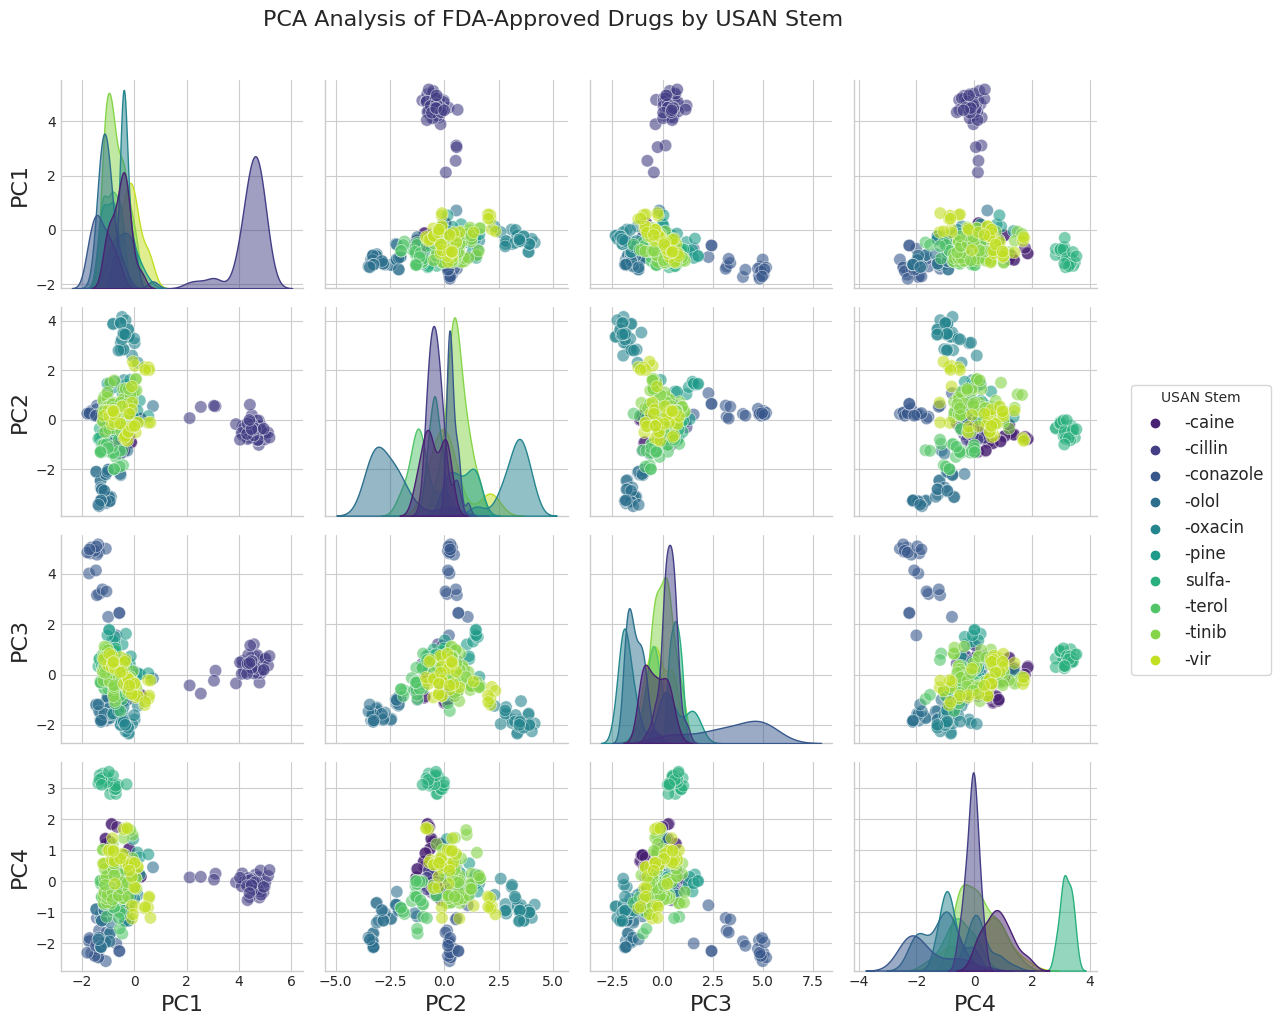

In [35]:
def plot_pca_results(df, group_col='USAN Stem', pc_cols=None):
    """
    Create visualizations of PCA results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing PCA results
    group_col : str
        Column name for grouping/coloring
    pc_cols : list
        List of principal component columns to include
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the visualization
    """
    if pc_cols is None:
        pc_cols = [f'PC{i+1}' for i in range(4)]
    
    # Create pairplot
    plt.figure(figsize=(12, 10))
    pairplot = sns.pairplot(
        df, 
        hue=group_col, 
        vars=pc_cols, 
        height=2.5,
        palette='viridis',
        diag_kind='kde',
        plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'w', 'linewidth': 0.5},
        diag_kws={'alpha': 0.5, 'fill': True}
    )
    
    # Add title
    pairplot.figure.suptitle('PCA Analysis of FDA-Approved Drugs by USAN Stem', 
                          y=1.02, fontsize=16)
    
    # Improve legend
    handles = pairplot._legend_data.values()
    labels = pairplot._legend_data.keys()
    
    pairplot._legend.remove()
    pairplot.figure.legend(handles=handles, labels=labels, 
                       loc='center right', bbox_to_anchor=(1.15, 0.5),
                       frameon=True, fontsize=12, title='USAN Stem')
    
    pairplot.figure.tight_layout()
    return pairplot.fig

# Create and display PCA visualization
pca_fig = plot_pca_results(fda_approved_df)

In [36]:
# Save the visualization
plt.savefig('figures/ch01/pca_pairplot.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch01/pca_pairplot.svg', bbox_inches='tight', dpi=600)

<Figure size 640x480 with 0 Axes>

#### <b> <font color='#A20025'> Supervised Learning Example: Logistic Regression

Now let's apply a supervised learning approach to see if we can classify drugs based on their USAN stems using their principal components. We'll:
 
1. Create binary target variables for two USAN stems: '-cillin' (antibiotics) and '-olol' (beta blockers)
2. Train logistic regression models to predict these drug classes
3. Visualize the decision boundaries

In [37]:
def prepare_classification_targets(df, stems_to_classify):
    """
    Create binary target variables for specific USAN stems.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing USAN stem information
    stems_to_classify : list
        List of USAN stems to create target variables for
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe with added binary target variables
    """
    for stem in stems_to_classify:
        stem_col = stem.replace('-', '')  # Create valid column name
        df[stem_col] = (df['USAN Stem'] == stem).astype(int)
        print(f"Created target variable '{stem_col}' with {df[stem_col].sum()} positive examples")
    
    return df

# Define USAN stems for classification
stems_to_classify = ['-cillin', '-olol']

# Create binary target variables
fda_approved_df = prepare_classification_targets(fda_approved_df, stems_to_classify)

Created target variable 'cillin' with 46 positive examples
Created target variable 'olol' with 37 positive examples


In [38]:
def train_and_visualize_classifier(df, target_col, feature_cols, title):
    """
    Train a logistic regression classifier and visualize its decision boundary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing features and target
    target_col : str
        Column name for the target variable
    feature_cols : list
        List of feature column names (should be exactly 2 for visualization)
    title : str
        Title for the plot
        
    Returns:
    --------
    sklearn.linear_model.LogisticRegression
        Trained classifier
    matplotlib.figure.Figure
        Figure containing the visualization
    """
    if len(feature_cols) != 2:
        raise ValueError("Exactly 2 feature columns required for visualization")
    
    # Extract features and target
    X = df[feature_cols].values
    y = df[target_col].values
    
    # Train logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X, y)
    
    # Create a meshgrid for visualization
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    
    # Calculate predictions on the meshgrid
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot decision boundary
    contour = ax.contourf(xx, yy, Z, 25, cmap='Blues', alpha=0.7, vmin=0, vmax=1)
    ax_c = fig.colorbar(contour)
    ax_c.set_label(f"Probability of {target_col}")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    # Plot data points
    scatter = ax.scatter(
        X[:, 0], X[:, 1], 
        c=y, s=100, cmap='Blues', 
        vmin=-0.2, vmax=1.2,
        edgecolor='black', linewidth=1.5
    )
    
    # Add labels and title
    ax.set(
        aspect='equal',
        xlabel=feature_cols[0], 
        ylabel=feature_cols[1],
        title=title
    )
    
    fig.tight_layout()
    return model, fig

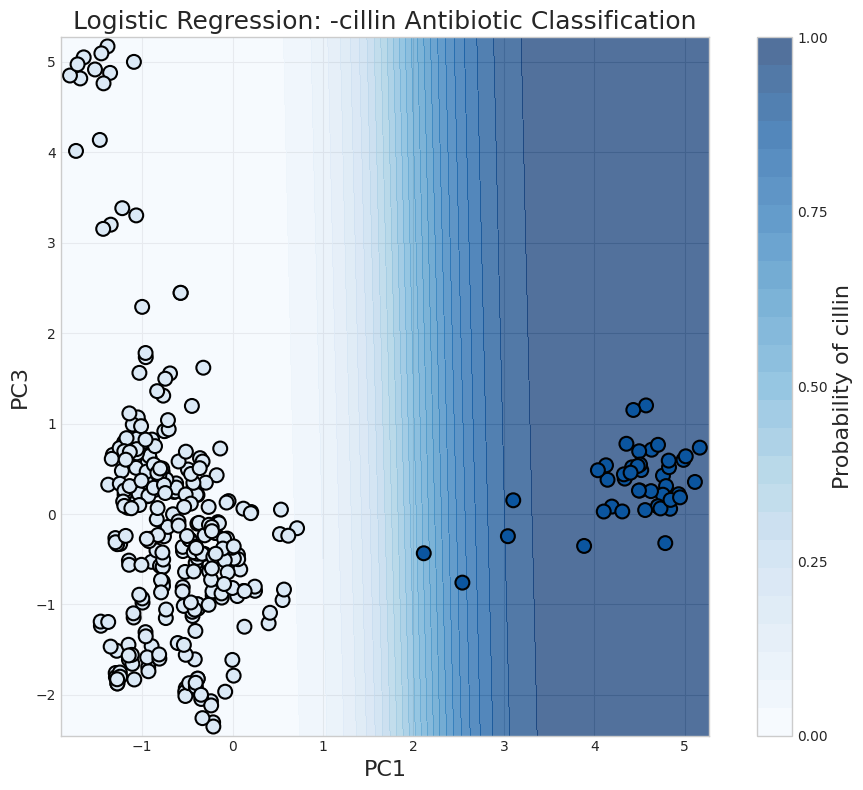

In [39]:
# Train and visualize model for -cillin classification
cillin_model, cillin_fig = train_and_visualize_classifier(
    df=fda_approved_df,
    target_col='cillin',
    feature_cols=['PC1', 'PC3'],
    title='Logistic Regression: -cillin Antibiotic Classification'
)

In [40]:
# Calculate and display accuracy
cillin_acc = cillin_model.score(
    fda_approved_df[['PC1', 'PC3']], 
    fda_approved_df['cillin']
)
print(f"Accuracy for -cillin classification: {cillin_acc:.4f}")

# Save the visualization
cillin_fig.savefig('figures/ch01/cillin_decision_boundary.png', bbox_inches='tight', dpi=600)
cillin_fig.savefig('figures/ch01/cillin_decision_boundary.svg', bbox_inches='tight', dpi=600)

/home/nflynn/anaconda3/envs/ml4dd/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy for -cillin classification: 1.0000


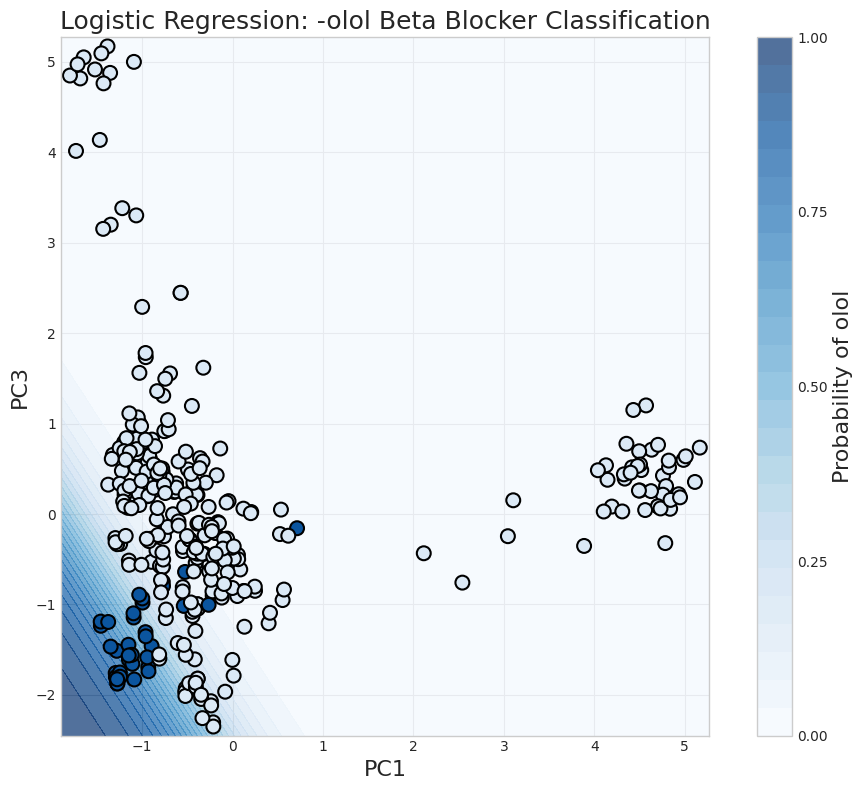

In [41]:
# Train and visualize model for -olol classification
olol_model, olol_fig = train_and_visualize_classifier(
    df=fda_approved_df,
    target_col='olol',
    feature_cols=['PC1', 'PC3'],
    title='Logistic Regression: -olol Beta Blocker Classification'
)

In [42]:
# Calculate and display accuracy
olol_acc = olol_model.score(
    fda_approved_df[['PC1', 'PC3']], 
    fda_approved_df['olol']
)
print(f"Accuracy for -olol classification: {olol_acc:.4f}")

# Save the visualization
olol_fig.savefig('figures/ch01/olol_decision_boundary.png', bbox_inches='tight', dpi=600)
olol_fig.savefig('figures/ch01/olol_decision_boundary.svg', bbox_inches='tight', dpi=600)

/home/nflynn/anaconda3/envs/ml4dd/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy for -olol classification: 0.9563


## <b> <font color='#A20025'> 3️⃣ Introducing Drug Discovery

**Companion code does not accompany this section of the book.**

*This section in the book covers the overall drug discovery process, including:*
 
- Target identification and validation
- Hit identification
- Lead optimization
- Preclinical development
- Clinical trials
- Regulatory approval
 
*The examples above demonstrate computational methods that support various stages in this process.*

## <b> <font color='#A20025'> Summary

In this notebook, we've explored:
 
1. **How to represent and visualize molecules** using RDKit
2. **Unsupervised learning (PCA)** to explore the chemical space of FDA-approved drugs
3. **Supervised learning (Logistic Regression)** to classify drugs based on their chemical features
 
These fundamental techniques form the basis for more advanced machine learning applications in drug discovery that we'll explore in later chapters.

## <b> <font color='#A20025'> Interactive Exploration

As you progress through the book, and as we cover additional concepts, consider returing back to this notebook and experimenting with the code above by:
 
1. Choosing different USAN stems to analyze
2. Using different molecular fingerprints (e.g., MACCS keys, topological fingerprints)
3. Training models with different principal components
4. Exploring other molecular descriptors available in RDKit

*See the book for more exercises.*

## <b> <font color='#A20025'> References and Further Reading

- RDKit Documentation: [https://www.rdkit.org/docs/](https://www.rdkit.org/docs/)
- The FDA's Approved Drug Products: [https://www.accessdata.fda.gov/scripts/cder/daf/](https://www.accessdata.fda.gov/scripts/cder/daf/)
- Lipinski, C.A. et al. (1997). Experimental and computational approaches to estimate solubility and permeability in drug discovery and development settings. *Adv. Drug Deliv. Rev.* 23, 3-25
- Appendix B: Chemical Data Repositories of this book for ideas on data sources and best practices for using them in your own projects.